# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.
# План работы

**1. Провести исследовательский анализ набора фотографий.**

Загрузите данные и выполните их первичный осмотр.

**2. Обучение модели**

Необхадимо провести масштабирование данных, и разделить на выборки. Провести обучение модели

**3. Вывод и общие рекомендации**

Сделайте общий вывод о проделанной работе: опишите основные этапы работы, полученные результаты и дайте рекомендации.

## Исследовательский анализ данных
**Посмотрите на размер выборки**

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from PIL import Image
import matplotlib.pyplot as plt

In [71]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Загрузчик нашёл 7591 фотографию

In [72]:
features, target = next(train_gen_flow)
print('features:', features.shape)
print('target:  ', target.shape)

features: (32, 224, 224, 3)
target:   (32,)


Получились признаки — четырёхмерный тензор, в котором 32 изображения размером 224х224 с тремя цветовыми каналами, тк изображение цветное.

**Постройте график распределения возраста в выборке**

In [30]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [31]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


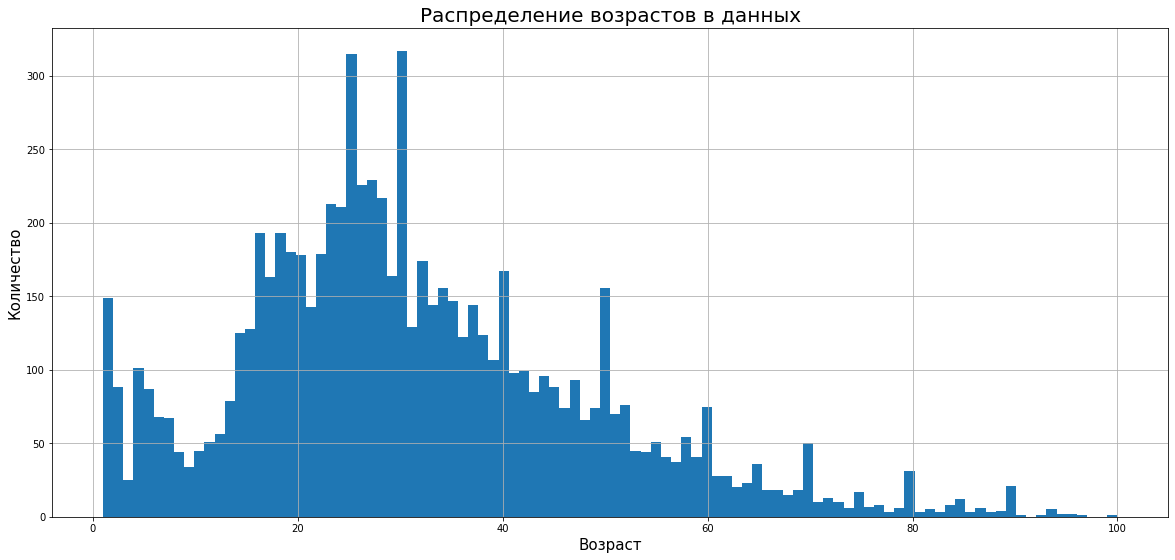

In [32]:
labels.real_age.hist(bins=100, figsize=(20, 9))
plt.title('Распределение возрастов в данных', fontsize=20)
plt.xlabel('Возраст', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.show()

**Медианный возраст 29 лет**

**Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет**

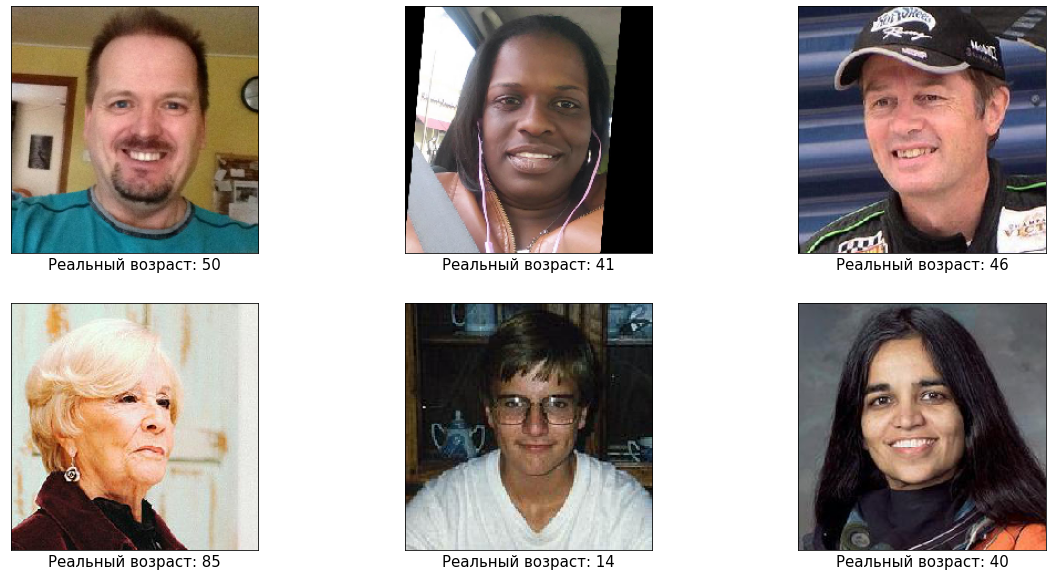

In [73]:
fig = plt.figure(figsize=(20,10))
for i in range(6):
    fig.add_subplot(2, 3, i+1)
    plt.imshow(features[i])
    plt.xlabel(f'Реальный возраст: {target[i]}', fontsize=15)
    plt.xticks([])
    plt.yticks([])  

**Вывод**:
* Датасет представлен 7591 фотографией
* В основном возраст находится в диапазоне от 20 до 41, медианный возраст 29
* Фотографии представленные в датасете имеют небольшие скошенности, в некоторых наблюдается смазанность, что усложнит обучение модели

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
        )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model


```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >
Train for 356 steps, validate for 119 steps
Epoch 1/5
2024-10-09 16:03:29.279345: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-10-09 16:03:29.652563: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 64s - loss: 207.7101 - mae: 11.0201 - val_loss: 294.1718 - val_mae: 12.8264
Epoch 2/5
356/356 - 49s - loss: 135.7556 - mae: 8.9101 - val_loss: 275.6217 - val_mae: 12.4172
Epoch 3/5
356/356 - 47s - loss: 111.2309 - mae: 8.0543 - val_loss: 166.6461 - val_mae: 9.8709
Epoch 4/5
356/356 - 48s - loss: 89.2218 - mae: 7.1692 - val_loss: 149.6061 - val_mae: 9.1132
Epoch 5/5
356/356 - 47s - loss: 73.7572 - mae: 6.5786 - val_loss: 106.9704 - val_mae: 7.8218
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 106.9704 - mae: 7.8218
Test MAE: 7.8218

```

**Вывод:** Модель обучилась на 5 эпохах, с точностью MAE = 7.82

## Вывод и общие рекомендации

**Вывод:**

Исследовательский анализ:
* Проведён исследовательский анализ датасета, в котором было выявлено, что средний диапазон возраста в нём состовляет от 20 до 41 года
* Некоторые фотографии имеют небольшую скошенность и размытость, что усложняет обучение модели

Обучение и тестирование модели:

* За основу взята модель ResNet50, предобученная на данных ImageNet1000. Для обучения было выбрано 5 эпох.
* Основная причина выбора ResNet50, состояла в том, что у неё есть дополнительные связи `Shortcut Connections`, благодаря которым можно избежать проблемы затухающего градиента
* Удалось добиться значения MAE ниже 8, что удволетворяет условию. Значение на тестовых данных состовляет MAE = 7.8218
* Для избежания переобучения, были заморожены сверточне слои ResNet50. Был добавлен полносвязный слой на 64 нейрона для обучения модели, а также был добавлен слой выхода модели на 1 нейрон. В качестве функции активации использовалась  `ReLu`, тк значения ниже нуля она зануляет, а значения выше оставляет без изминений.

Рекомендации: В 75% данных представлены люди возрастом до 41 года, для улучшения предсказательной способности нужно увеличить данные включая людей возрастом от 42 лет и более